# Within-host single nucleotide variants 

**Date**: 2020-01-23
**Author**: Katarina Braun 


## Overview
- I made a list of all of the SNVs found at all timepoints in the Guangdong ferrets (not the recombinant ferrets) as well as the Anhui ferrets. Using Nexstrain, I evaluted the number of times that SNV has been detected in human or avian sequences. I then calculated the proportional representation of that SNV in mammalian or avian sequences by dividing by the total number of sequences available in Nexstrain (I did this to avoid sampling bias). I recorded each SNV as "avian" if the SNV was enriched in avian sequences and "mammalian" if the SNV was enriched on human sequences. If the SNV was not found in any surveillance sequences or was only found in environmental samples, I recorded the SNV as "not found"
- Using the list of SNVs + avian/mammalian designation, I am going to plot SNV frequency along the Y and genome location along the X, I'll then color the SNVs according to whether they ar enriched on mammalian or avian sequences. 
- Note: I only looked at nonsynonymous SNVs for this 
- The average frequency is the mean of all frequencies where that SNV was detected in GD3 ferrets and Anhui ferrets 

### Note about HA numbering: 
For H7N9, I used H7 numbering. This numbering scheme matches the numbering scheme on Nextstrain (https://nextstrain.org/).  
For H1N1pdm, I use H1 numbering. Again, this numbering scheme matches the numbering scheme on Nextstrain. For clarity, I start counting amino acids at nucleotide #51, AA #18 (D). 

## Input: 

Input file contains list of SNVs in GD3 and Anhui ferrets at all timepoints as well as wehther this SNV is enriched in avian or mammalian sequences (Nexstrain) and the average frequency that that SNV was found in this group of animals. 

The script `edit-snv-files-to-generate-list-of-snvs-to-annotate.ipynb` contains the code I used to combine SNVs across cleaned VCFs as well as to calculate the average frequency per SNV. 

The input file for this notebook is here:  
`H7N9-evolution-in-mammals/data_derived/avian_vs_mammalian/avian_or_mammalian_with_avg_frequency.csv`

## Output: 

This script generates figure 8:   `H7N9-evolution-in-mammals/figures/figure8.pdf`

## import modules and dependencies

In [106]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rc

In [84]:
# load the SNV csv file 
SNVs = pd.read_csv('../data_derived/avian_vs_mammalian/avian_or_mammalian_with_adaptive_SNVs_highlighted.csv', sep=',')

# split the SNP column by "_" so I can extract genome position 
SNVs['nuc_SNV'] = SNVs['SNP'].str.split('_').str[1]
SNVs['gene'] = SNVs['SNP'].str.split('_').str[0]
SNVs['nucleotide_position'] = SNVs.nuc_SNV.str.extract('(\d+)')
SNVs['average_freq'] = SNVs['average_freq'] * 100
SNVs['nucleotide_position'] = pd.to_numeric(SNVs['nucleotide_position'])

# slice the large dataframe into individual genes so I can edit the numbering scheme 
PB2 = SNVs[SNVs["gene"].str.contains("PB2")]
PB1 = SNVs[SNVs["gene"].str.contains("PB1")]
PA = SNVs[SNVs["gene"].str.contains("PA")]
HA = SNVs[SNVs["gene"].str.contains("HA")]
NP = SNVs[SNVs["gene"].str.contains("NP")]
NA = SNVs[SNVs["gene"].str.contains("NA")]
M1 = SNVs[SNVs["gene"].str.contains("M1")]
M2 = SNVs[SNVs["gene"].str.contains("M2")]
NS1 = SNVs[SNVs["gene"].str.contains("NS1")]
NEP = SNVs[SNVs["gene"].str.contains("NEP")]

In [85]:
SNVs

,Unnamed: 0,FREQ,SNP,average_freq,avian_or_mammalian,adaptive?,nuc_SNV,gene,nucleotide_position
0,0,0.0140,HA_C140T_A47V,1.400000,not_found,#ffffff00,C140T,HA,140
1,1,0.0194,HA_G194A_R65K,1.795000,avian,#ffffff00,G194A,HA,194
2,2,0.0556,HA_C236T_T79I,5.086667,mammalian,#ffffff00,C236T,HA,236
3,3,0.8810,HA_G410A_G137E,79.965000,avian,#ffffff00,G410A,HA,410
4,4,0.0130,HA_G416T_R139I,1.340000,not_found,#ffffff00,G416T,HA,416
5,5,0.0274,HA_G416A_R139K,3.296000,avian,#ffffff00,G416A,HA,416
6,6,0.0976,HA_C419T_T140I,6.576667,avian,#ffffff00,C419T,HA,419
7,7,0.2052,HA_A421G_N141D,36.329375,mammalian,#ffffff00,A421G,HA,421
8,8,0.2636,HA_G427A_A143T,15.342857,mammalian,#F1B31B,G427A,HA,427
9,9,0.0167,HA_A442G_R148G,1.670000,mammalian,#ffffff00,A442G,HA,442


In [86]:
# ignore some errors that will pop up 
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


# add a column with color designations for the plot 
PB2['color'] = pd.np.where(PB2.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(PB2.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(PB2.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))
PB1['color'] = pd.np.where(PB1.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(PB1.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(PB1.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))
PA['color'] = pd.np.where(PA.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(PA.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(PA.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))
HA['color'] = pd.np.where(HA.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(HA.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(HA.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))
NP['color'] = pd.np.where(NP.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(NP.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(NP.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))
NA['color'] = pd.np.where(NA.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(NA.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(NA.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))
M1['color'] = pd.np.where(M1.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(M1.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(M1.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))
M2['color'] = pd.np.where(M2.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(M2.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(M2.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))
NS1['color'] = pd.np.where(NS1.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(NS1.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(NS1.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))
NEP['color'] = pd.np.where(NEP.avian_or_mammalian.str.contains("avian"), "#197278",
                   pd.np.where(NEP.avian_or_mammalian.str.contains("mammalian"), "#C44536",
                   pd.np.where(NEP.avian_or_mammalian.str.contains("not_found"), "#BFC3BA", "task")))

## make the plot

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


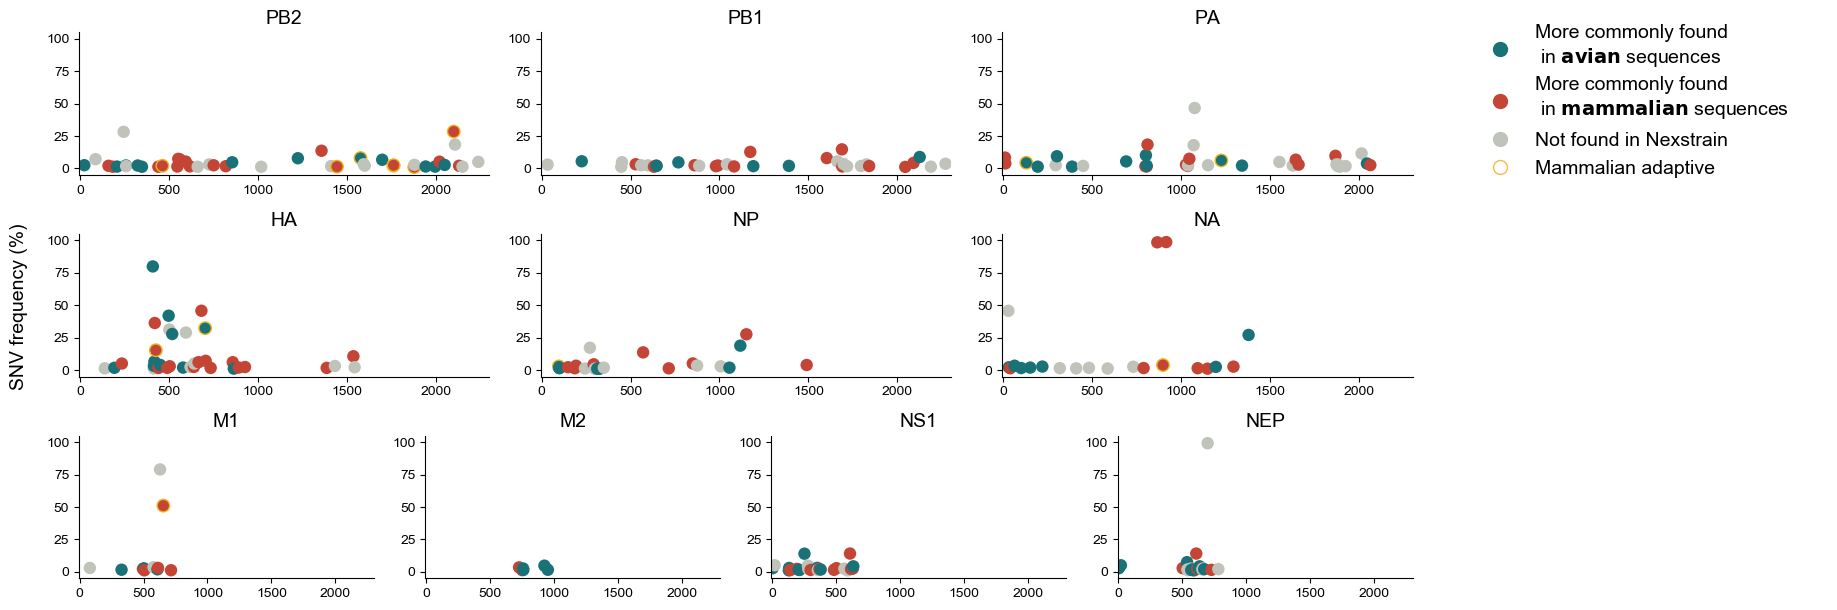

In [122]:
# generate a figure with sub-plots (one for each gene segment)
fig8 = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(4, 12)

ax1 = fig8.add_subplot(gs[0,0:4]) #PB2
ax2 = fig8.add_subplot(gs[0,4:8]) #PB1
ax3 = fig8.add_subplot(gs[0,8:12]) #PA
ax4 = fig8.add_subplot(gs[1,0:4]) #HA
ax5 = fig8.add_subplot(gs[1,4:8]) #NP
ax6 = fig8.add_subplot(gs[1,8:12]) #NA
ax7 = fig8.add_subplot(gs[2,0:3]) #M1
ax8 = fig8.add_subplot(gs[2,3:6]) #M2
ax9 = fig8.add_subplot(gs[2,6:9]) #NS1
ax10 = fig8.add_subplot(gs[2,9:12]) #NEP

# get right of top and right frame of each subplot
axes = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# PB2 (ax1) 
ax1.set_title('PB2', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-5,105)
ax1.set_xlim(-5,2300)
ax1.set_xticks([0, 500, 1000, 1500, 2000])
ax1.scatter(x=PB2['nucleotide_position'], y=PB2['average_freq'], marker='o', edgecolor=PB2['adaptive?'], color=PB2['color'], s=80)

# PB1 (ax2) 
ax2.set_title('PB1', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-5,105)
ax2.set_xlim(-5,2300)
ax2.set_xticks([0, 500, 1000, 1500, 2000])
ax2.scatter(x=PB1['nucleotide_position'], y=PB1['average_freq'], marker='o', edgecolor=PB1['adaptive?'], color=PB1['color'], s=80)

# PA (ax3) 
ax3.set_title('PA', fontname='Arial', fontsize=14)
ax3.set_facecolor('white')
for tick in ax3.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Arial")
ax3.set_ylim(-5,105)
ax3.set_xlim(-5,2300)
ax3.set_xticks([0, 500, 1000, 1500, 2000])
ax3.scatter(x=PA['nucleotide_position'], y=PA['average_freq'], marker='o', edgecolor=PA['adaptive?'], color=PA['color'], s=80)

# HA (ax4) 
ax4.set_title('HA', fontname='Arial', fontsize=14)
ax4.set_facecolor('white')
for tick in ax4.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax4.get_yticklabels():
    tick.set_fontname("Arial")
ax4.set_ylim(-5,105)
ax4.set_xlim(-5,2300)
ax4.set_xticks([0, 500, 1000, 1500, 2000])
ax4.scatter(x=HA['nucleotide_position'], y=HA['average_freq'], marker='o', edgecolor=HA['adaptive?'], color=HA['color'], s=80)

# NP (ax5) 
ax5.set_title('NP', fontname='Arial', fontsize=14)
ax5.set_facecolor('white')
for tick in ax5.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax5.get_yticklabels():
    tick.set_fontname("Arial")
ax5.set_ylim(-5,105)
ax5.set_xlim(-5,2300)
ax5.set_xticks([0, 500, 1000, 1500, 2000])
ax5.scatter(x=NP['nucleotide_position'], y=NP['average_freq'], marker='o', edgecolor=NP['adaptive?'], color=NP['color'], s=80)

# NA (ax6) 
ax6.set_title('NA', fontname='Arial', fontsize=14)
ax6.set_facecolor('white')
for tick in ax6.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax6.get_yticklabels():
    tick.set_fontname("Arial")
ax6.set_ylim(-5,105)
ax6.set_xlim(-5,2300)
ax6.set_xticks([0, 500, 1000, 1500, 2000])
ax6.scatter(x=NA['nucleotide_position'], y=NA['average_freq'], marker='o', edgecolor=NA['adaptive?'], color=NA['color'], s=80)

# M1 (ax7) 
ax7.set_title('M1', fontname='Arial', fontsize=14)
ax7.set_facecolor('white')
for tick in ax7.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax7.get_yticklabels():
    tick.set_fontname("Arial")
ax7.set_ylim(-5,105)
ax7.set_xlim(-5,2300)
ax7.set_xticks([0, 500, 1000, 1500, 2000])
ax7.scatter(x=M1['nucleotide_position'], y=M1['average_freq'], marker='o', edgecolor=M1['adaptive?'], color=M1['color'], s=80)

# M2 (ax8) 
ax8.set_title('M2', fontname='Arial', fontsize=14)
ax8.set_facecolor('white')
for tick in ax8.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax8.get_yticklabels():
    tick.set_fontname("Arial")
ax8.set_ylim(-5,105)
ax8.set_xlim(-5,2300)
ax8.set_xticks([0, 500, 1000, 1500, 2000])
ax8.scatter(x=M2['nucleotide_position'], y=M2['average_freq'], marker='o', edgecolor=M2['adaptive?'], color=M2['color'], s=80)

# NS1 (ax9) 
ax9.set_title('NS1', fontname='Arial', fontsize=14)
ax9.set_facecolor('white')
for tick in ax9.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax9.get_yticklabels():
    tick.set_fontname("Arial")
ax9.set_ylim(-5,105)
ax9.set_xlim(-5,2300)
ax9.set_xticks([0, 500, 1000, 1500, 2000])
ax9.scatter(x=NS1['nucleotide_position'], y=NS1['average_freq'], marker='o', edgecolor=NS1['adaptive?'], color=NS1['color'], s=80)

# NEP (ax10) 
ax10.set_title('NEP', fontname='Arial', fontsize=14)
ax10.set_facecolor('white')
for tick in ax10.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax10.get_yticklabels():
    tick.set_fontname("Arial")
ax10.set_ylim(-5,105)
ax10.set_xlim(-5,2300)
ax10.set_xticks([0, 500, 1000, 1500, 2000])
ax10.scatter(x=NEP['nucleotide_position'], y=NEP['average_freq'], marker='o', edgecolor=NEP['adaptive?'], color=NEP['color'], s=80)

# add a common x axis label for the entire figure 
fig8.text(-0.015, 0.61, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a legend to this plot
avian = mlines.Line2D([], [], marker='o', color="#197278", linestyle='None', markersize=10, label="More commonly found \n in " + r"$\bf{avian}$" + " sequences")
mammalian = mlines.Line2D([], [], marker='o', color="#C44536", linestyle='None', markersize=10, label="More commonly found \n in " + r"$\bf{mammalian}$" + " sequences")
not_found = mlines.Line2D([], [], marker='o', color="#BFC3BA", linestyle='None', markersize=10, label='Not found in Nexstrain')
halo = Line2D([0], [0], marker='o', color='#F4BB47', markerfacecolor='white', linestyle='None', markersize=10, label='Mammalian adaptive')
fig8.legend(handles=[avian, mammalian, not_found, halo], frameon=False, fontsize=14, bbox_to_anchor=(1.29,0.75))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig8.tight_layout()
fig8.show()

# save this plot to the figures folder 
fig8.savefig("../figures/figure8.pdf", bbox_inches='tight', dpi=300)

##